This notebook explores the raw `steam-200k.csv` dataset and the processed
outputs from the `steam_real` pipeline.

Goals:

- understand the raw schema of the `steam-200k` dataset  
- inspect basic distributions (behavior, value, games)  
- look at the processed `session_events.parquet`  
- get a first view of the `ml_dataset.parquet` that will feed the churn model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
sns.set(style="whitegrid")

In [3]:
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

In [4]:
RAW_PATH = RAW_DIR / "steam-200k.csv"
SESSION_EVENTS_PATH = PROCESSED_DIR / "session_events.parquet"
ML_DATASET_PATH = PROCESSED_DIR / "ml_dataset.parquet"

In [5]:
PROJECT_ROOT, DATA_DIR

(PosixPath('/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/steam_real'),
 PosixPath('/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/steam_real/data'))

## Loading raw `steam-200k` data

The `steam-200k.csv` file comes without a header.  
We assign column names and take a quick look at the structure.

In [6]:
raw_df = pd.read_csv(RAW_PATH, header=None)

In [7]:
base_cols = ["user_id", "game_name", "behavior", "value"]
for i, col in enumerate(base_cols):
    if i < raw_df.shape[1]:
        raw_df.rename(columns={raw_df.columns[i]: col}, inplace=True)
raw_df.head()

,user_id,game_name,behavior,value,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    200000 non-null  int64  
 1   game_name  200000 non-null  object 
 2   behavior   200000 non-null  object 
 3   value      200000 non-null  float64
 4   4          200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


We expect:

- `user_id`: identifier of the player  
- `game_name`: title of the game  
- `behavior`: usually `"play"` or `"purchase"`  
- `value`: numeric value, often minutes or hours depending on the dataset  

Next we check basic distributions.

In [9]:
raw_df["behavior"].value_counts(dropna=False)

behavior
purchase    129511
play         70489
Name: count, dtype: int64

In [10]:
raw_df["value"] = pd.to_numeric(raw_df["value"], errors="coerce")
raw_df["value"].describe()

count    200000.000000
mean         17.874384
std         138.056952
min           0.100000
25%           1.000000
50%           1.000000
75%           1.300000
max       11754.000000
Name: value, dtype: float64

In [11]:
raw_df["game_name"].value_counts().head(20)

game_name
Dota 2                             9682
Team Fortress 2                    4646
Counter-Strike Global Offensive    2789
Unturned                           2632
Left 4 Dead 2                      1752
Counter-Strike Source              1693
Counter-Strike                     1424
Garry's Mod                        1397
The Elder Scrolls V Skyrim         1394
Warframe                           1271
Half-Life 2 Lost Coast             1158
Sid Meier's Civilization V         1150
Robocraft                          1096
Half-Life 2 Deathmatch             1021
Portal                             1005
Portal 2                            997
Half-Life 2                         995
Heroes & Generals                   993
Terraria                            956
Counter-Strike Condition Zero       904
Name: count, dtype: int64

## Filtering to `play` events

The pipeline keeps only `"play"` events to build engagement features.
We mirror that here and look at the filtered view.

In [12]:
play_df = raw_df[raw_df["behavior"] == "play"].copy()
play_df.head()

,user_id,game_name,behavior,value,4
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
3,151603712,Fallout 4,play,87.0,0
5,151603712,Spore,play,14.9,0
7,151603712,Fallout New Vegas,play,12.1,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [13]:
play_df["value"].describe()

count    70489.000000
mean        48.878063
std        229.335236
min          0.100000
25%          1.000000
50%          4.500000
75%         19.100000
max      11754.000000
Name: value, dtype: float64

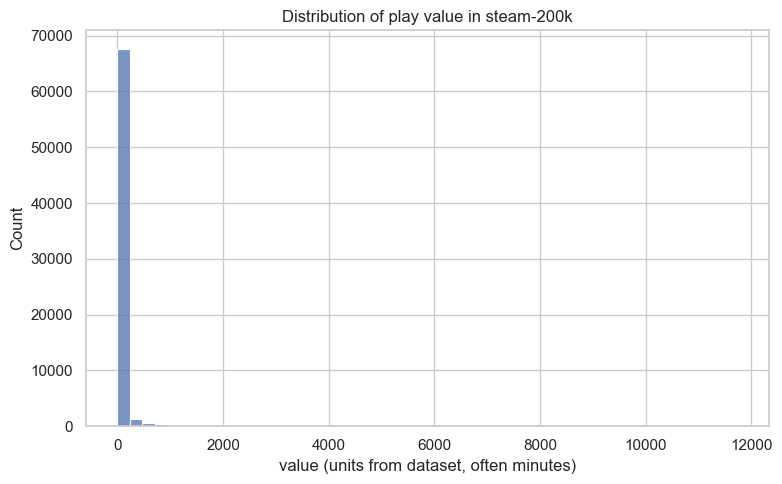

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(play_df["value"].dropna(), bins=50)
plt.xlabel("value (units from dataset, often minutes)")
plt.title("Distribution of play value in steam-200k")
plt.tight_layout()
plt.show()

In [15]:
play_df["value"].quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50      4.5
0.75     19.1
0.90     76.0
0.95    189.0
0.99    908.0
Name: value, dtype: float64

## Loading `session_events.parquet`

The ingestion step groups the data to `(user_id, game_name)` level and
computes:

- `total_playtime_value`: total sum of `value`  
- `sessions`: count of play events for that user and game  

Now we inspect that table.

In [16]:
session_df = pd.read_parquet(SESSION_EVENTS_PATH)
session_df.head()

,user_id,game_name,total_playtime_value,sessions
0,5250,Alien Swarm,4.9,1
1,5250,Cities Skylines,144.0,1
2,5250,Deus Ex Human Revolution,62.0,1
3,5250,Dota 2,0.2,1
4,5250,Portal 2,13.6,1


In [17]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70477 entries, 0 to 70476
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               70477 non-null  int64  
 1   game_name             70477 non-null  object 
 2   total_playtime_value  70477 non-null  float64
 3   sessions              70477 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.2+ MB


In [18]:
session_df[["total_playtime_value", "sessions"]].describe()

,total_playtime_value,sessions
count,70477.000000,70477.000000
mean,48.886386,1.000170
std,229.353917,0.013048
min,0.100000,1.000000
25%,1.000000,1.000000
50%,4.500000,1.000000
75%,19.100000,1.000000
max,11754.000000,2.000000


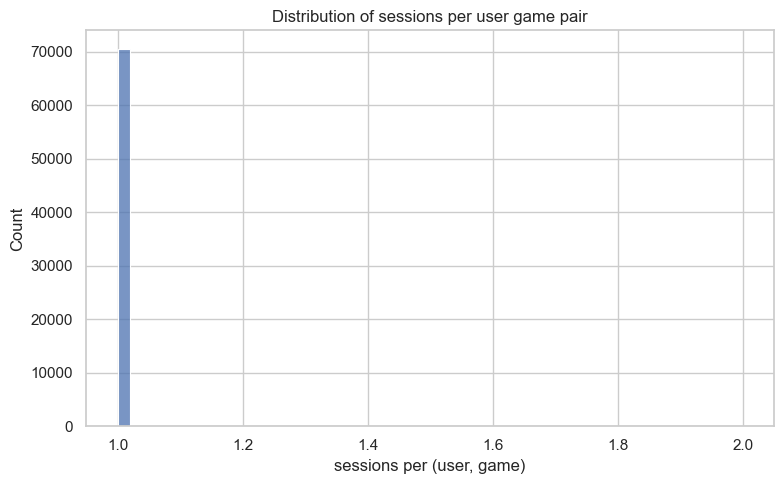

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(session_df["sessions"], bins=50)
plt.xlabel("sessions per (user, game)")
plt.title("Distribution of sessions per user game pair")
plt.tight_layout()
plt.show()

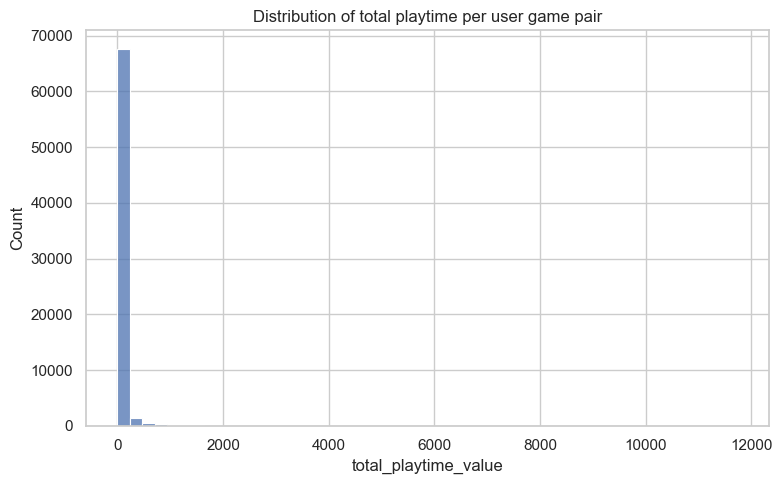

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(session_df["total_playtime_value"], bins=50)
plt.xlabel("total_playtime_value")
plt.title("Distribution of total playtime per user game pair")
plt.tight_layout()
plt.show()

## Loading `ml_dataset.parquet`

The feature pipeline aggregates to user level and builds:

- total playtime, session counts, unique games  
- simple derived features  
- a proxy churn label based on total playtime  

We load and inspect that dataset.

In [21]:
ml_df = pd.read_parquet(ML_DATASET_PATH)
ml_df.head()

,user_id,total_playtime_value,sessions,unique_games,avg_session_length,playtime_per_game,churned
0,5250,225.5,6,6,37.583333,37.583333,0
1,76767,1227.0,20,20,61.350000,61.350000,0
2,86540,255.0,15,15,17.000000,17.000000,0
3,144736,0.1,1,1,0.100000,0.100000,1
4,181212,2.2,2,2,1.100000,1.100000,0


In [22]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11350 entries, 0 to 11349
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               11350 non-null  int64  
 1   total_playtime_value  11350 non-null  float64
 2   sessions              11350 non-null  int64  
 3   unique_games          11350 non-null  int64  
 4   avg_session_length    11350 non-null  float64
 5   playtime_per_game     11350 non-null  float64
 6   churned               11350 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 620.8 KB


In [23]:
ml_df["churned"].value_counts(normalize=True)

churned
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [24]:
feature_cols = [
    "total_playtime_value",
    "sessions",
    "unique_games",
    "avg_session_length",
    "playtime_per_game",
]
ml_df[feature_cols].describe()

,total_playtime_value,sessions,unique_games,avg_session_length,playtime_per_game
count,11350.000000,11350.000000,11350.000000,11350.000000,11350.000000
mean,303.556458,6.210485,6.209427,81.151107,81.154455
std,789.541803,17.758660,17.754906,295.566130,295.566277
min,0.100000,1.000000,1.000000,0.100000,0.100000
25%,2.300000,1.000000,1.000000,1.900000,1.900000
50%,19.500000,1.000000,1.000000,10.250000,10.250000
75%,198.975000,3.000000,3.000000,45.412392,45.412392
max,11754.000000,498.000000,498.000000,11754.000000,11754.000000


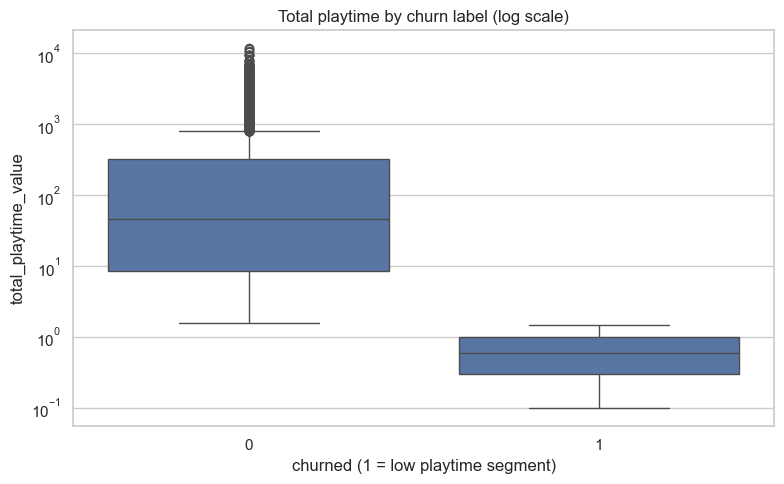

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=ml_df,
    x="churned",
    y="total_playtime_value",
)
plt.yscale("log")
plt.xlabel("churned (1 = low playtime segment)")
plt.title("Total playtime by churn label (log scale)")
plt.tight_layout()
plt.show()

## Summary

By the end of this notebook we have:

- inspected the raw `steam-200k` logs and the play behavior distribution  
- looked at the aggregated `session_events.parquet`  
- explored the `ml_dataset.parquet` and the proxy churn label  

The next notebook will focus on retention style views and engagement tiers
built from these features.